# Neural Network from Scratch
Author: [Ryan Parker](https://github.com/rparkr)  
In this notebook, I implement a configurable fully connected neural network from scratch, then use it to create text embeddings.

I built this project to practice translating mathematical concepts (e.g., forward and backward prop, gradient descent) into vectorized code. As such, I relied only on math walkthroughs and did not reference anyone else's code as I built this algorithm. While studying the math for backpropagation, two of my favorite resources were:
- [3Blue1Brown: Backpropagation Calculus](https://www.3blue1brown.com/lessons/backpropagation-calculus)
- [Backprop scroll-through visualization](https://developers-dot-devsite-v2-prod.appspot.com/machine-learning/crash-course/backprop-scroll/)

**See also my other "from scratch" machine learning algorithms,** which include explanations of the mathematics behind them and visualizations of the training process and the models' predictions:
- [logistic regression](./logistic_regression_from_scratch.ipynb)
- [linear regression](./linear_regression_from_scratch.ipynb)

Some of the core concepts in fully connected neural networks come from linear regression (matrix multiplication of inputs with weights) and logistic regression (sigmoid activation function), so reviewing my other notebooks will give you a sense for the inner workings of the neural network I implement in this notebook.

## Results
These images show some of the results I achieved by training the from-scratch neural network for a few minutes on different datasets.

## Required packages
**I implement the entire neural network using only `NumPy`.**

The built-in package `typing.Union` is used for type annotations (code hints) for method parameters that can take multiple kinds of inputs. The built-in package `warnings` is used to issue warnings to the user without stopping code execution, such as informing the user that the input data type does not match the data type of the network's parameters.

The [Demos](#demos) section uses some additional packages for plotting and dataset preparation.

In [1]:
# built-in packages
from typing import Union  # type annotations for functions
import warnings  # send alerts to user without stopping code execution

# third-party packages
import numpy as np  # array-based computation
from tqdm.auto import tqdm  # progress bars, used in the train() method of the network

# Functions
In this section, I implement functions and their derivatives for use in the forward and backward passes of the neural network.

See the docstrings for each function for an explanation of what it does and how it works.

**Brief descriptions:**
- `sigmoid`: also known as the _logistic_ function, sigmoid is used as a non-linear activation function for this network
- `df_sigmoid`: the derivative of the sigmoid function, used in computing the _gradient_ during the backwards pass (_backpropagation_) through the network
- `relu`: **Re**ctified **L**inear **U**nits, a non-linear activation function used in the network
- `df_relu`: the derivative of ReLU
- `linear`: the standard linear function, which computes `z = wx + b` for any number of weight (`w`) parameters (where the number of weight parameters is equal to the number of inputs, `x`). For example, this function would also compute `z = w1x1 + w2x2 + w3x3 + b`. **Of particular note is that this function creates `z`, the input to the activation function for each network layer.** Note that the derivative for this function is implemented during the backpropagation steps in the network's `nn.backwards()` method, rather than as a standalone function.
- `mse_loss`: **M**ean **S**quared **E**rror loss, the loss function used for regression tasks. The loss function is what the network uses to _learn_: through gradient descent, the network's parameters (weights and biases) are updated to minimize the loss function.
- `df_mse_loss`: the derivative of the MSE loss function
- `softmax`: the _softmax_ function translates outputs into probability distributions across classes. It is applied after the final layer's outputs (activations) for classification tasks and is then fed into the Cross Entropy Loss function.
- `df_softmax`: the derivative of the softmax function. I describe it in the function's docstring, but don't actually implement the code for this derivative because the derivative of Cross Entropy Loss takes into account softmax as its input and becomes greatly simplified by combining both derivatives together into a single step.
- `cross_entropy_loss`: the loss function used for classification tasks.
- `df_cross_entropy_loss`: the derivative of the cross entropy loss function
- `one_hot_encode`: converts an array of shape `(m_samples,)` to one of shape `(m_samples, n_classes)` with a `1` at the class index and `0`s elsewhere. Generally used when the target array, `y`, for a classification task has shape `(m_samples,)` to get it in the format expected by the neural network: `(m_samples, n_classes)`.  
  For example, if there are 4 possible classes, a target array for 5 samples might look like: `[3, 0, 1, 3, 2]`, but the format needed for the neural network is:  
  ```python
  >>> one_hot_encode([3, 0, 1, 3, 2])
  [[0, 0, 0, 1],
   [1, 0, 0, 0],
   [0, 1, 0, 0],
   [0, 0, 0, 1],
   [0, 0, 1, 0]]
  ```

In [2]:
def sigmoid(z: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    '''Calculate probabilities using the sigmoid function on input data, z.
    The sigmoid, or logistic, function is used as an activation for
    neurons of a neural network because it is non-linear.

    Parameters
    ----------
    z: {float, np.ndarray}
        The input to be passed through the sigmoid function.
        Typically, input values come from a linear combination
        of input values with weights and a bias term. That is,
        some form of y = wx + b.

    Returns
    -------
    sigmoid_value: {float, np.ndarray}
        The output of the sigmoid function, in the same
        shape as the input.
    '''
    return 1 / (1 + np.exp(-z))


def df_sigmoid(z: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    '''Compute the derivative of the sigmoid function,
    which is sigmoid(z) * (1-sigmoid(z)).
    
    Parameters
    ----------
    z: {float, np.ndarray}
        The input to be passed through the sigmoid function.
        Typically, input values come from a linear combination
        of input values with weights and a bias term. That is,
        some form of y = wx + b.
    '''
    # See: https://beckernick.github.io/sigmoid-derivative-neural-network/
    out = sigmoid(z)
    return out * (1 - out)


def relu(x_input: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    '''Compute the Rectified Linear Unit activation function.'''
    return np.maximum(x_input, 0)


def df_relu(x_input: np.ndarray) -> np.ndarray:
    '''Compute the derivative of the ReLU activation function,
    which is 0 when x < 0 and 1 when x > 0.'''
    # First, set everything to zeros
    out = np.zeros_like(x_input)
    # Then set to 1 where x_input > 0
    out[x_input > 0] = 1
    return out


def linear(
        x_input: np.ndarray,
        weights: np.ndarray,
        bias: np.ndarray) -> np.ndarray:
    '''Compute a linear function: y = wx + b.
    
    Returns
    -------
    z: the computed value(s) after multiplying
        inputs by the weights and adding a bias.
    '''
    # Matrix-multiplication with the @ operator
    z = (x_input @ weights) + bias
    return z


def mse_loss(y_hat: np.ndarray, y_target: np.ndarray) -> float:
    '''Compute the mean squared error loss function.
    
    Parameters:
    ----------
    y_hat: array of shape (m_samples,)
        Predictions output from the model.
    y_target: array of shape (m_samples,)
        The true labels, or targets to predict.

    Returns:
    -------
    loss: float
        A measure of the average distance between predicted and target values.
    '''
    num_samples = y_hat.shape[0]
    # Below, dividing by 2m is the same as multiplying by (1/2m)
    return np.sum((y_hat - y_target) ** 2) / (2 * num_samples)


def df_mse_loss(y_hat: np.ndarray, y_target: np.ndarray) -> np.ndarray:
    '''Compute the derivative of mean-squared error loss with respect
    to the final outputs of the network. Returns the gradients of the
    activations from the final layer of the network.

    Used for regression problems, where the target is a continuous
    variable.
    
    Parameters
    ----------
    y_hat: array of shape (m_samples,)
        The network's outputs (predictions).
    y_target: array of shape (m_samples,)
        The labels being predicted, or "ground truth."
    
    Returns
    -------
    derivatives: array of shape (m_samples,)
        The derivative of the mean-squared error loss with respect
        to the output from the network.
    '''
    num_samples = y_hat.shape[0]
    return (y_hat - y_target) / num_samples


def softmax(x_input: np.ndarray, axis: int=1) -> np.ndarray:
    '''Compute the softmax function on an input array.
    
    Softmax creates a probability distribution across
    the input, where rank ordering is preserved but
    absolute values change such that the sum of all
    probability values output from softmax equals 1.

    Equation: e^x / sum(e^x) for all classes
    '''
    # e^x for all x
    e_x = np.exp(x_input)
    # Align the sum as a column using [:, np.newaxis]
    return e_x / np.sum(e_x, axis=axis)[:, np.newaxis]


def df_softmax(x_input: np.ndarray) -> np.ndarray:
    '''Compute the derivative of the softmax function 
    with respecct to an input array.
    
    Equation:
    For input index i = output index j:
        df_softmax = softmax(x_i) * (1 - softmax(x_i))
    For input position i != output position j:
        df_softmax = -softmax(x_i) * softmax(x_j)
    '''
    # First, the case where i != j
    # ...
    # We don't actually need to compute this,
    # because the derivative of cross entropy loss
    # with respect to the softmax outputs already 
    # takes this into account.
    pass


def cross_entropy_loss(y_hat: np.ndarray, y_target: np.ndarray) -> float:
    '''Compute the cross-entropy loss over the network's outputs.

    Equation: -sum(y_target * log(y_hat)) for all samples in the batch.
    
    Parameters
    ----------
    y_hat: array of shape (m_samples, n_classes)
        The network's outputs (predictions), after being
        passed through softmax to return a probability
        distribution across the classes.
    y_target: array of shape (m_samples, n_classes)
        A one-hot encoded array where each row is a sample
        and each column is a possible class, with a 1
        in the position of the correct class for that
        sample.
    
    Returns
    -------
    loss: float
        The cross-entropy loss for the given batch.
    
    '''
    num_samples = y_hat.shape[0]
    return -np.sum(y_target * np.log(y_hat)) / num_samples


def df_cross_entropy_loss(
        y_hat: np.ndarray, y_target: np.ndarray) -> np.ndarray:
    '''Compute the derivative of the cross-entropy loss funtion
    with respect to the output of the softmax function.
    
    Parameters
    ----------
    y_hat: array of shape (m_samples, n_classes)
        The network's outputs (predictions), after being
        passed through softmax to return a probability
        distribution across the classes.
    y_target: array of shape (m_samples, n_classes)
        A one-hot encoded array where each row is a sample
        and each column is a possible class, with a 1
        in the position of the correct class for that
        sample.
    
    Returns
    -------
    derivatives: array of shape (m_samples, n_classes)
        The derivative of cross-entropy loss with respect
        to the output from the softmax function.
    '''
    num_samples = y_hat.shape[0]
    return (y_hat - y_target) / num_samples


def one_hot_encode(input: np.ndarray) -> np.ndarray:
    '''Convert an array of shape `(m_samples,)` to one of shape
    `(m_samples, n_classes)` with a `1` at the class index and `0`s elsewhere.
    
    Generally used when the target array, `y`, for a classification task has
    shape `(m_samples,)` to get it in the format expected by the neural
    network: `(m_samples, n_classes)`.

    For example, if there are 4 possible classes (0-3), a target array for
    5 samples might look like: `[3, 0, 1, 3, 2]`, but the format needed for
    the neural network is:  
    ```
    >>> one_hot_encode([3, 0, 1, 3, 2])
    [[0, 0, 0, 1]
     [1, 0, 0, 0]
     [0, 1, 0, 0]
     [0, 0, 0, 1]
     [0, 0, 1, 0]]
    ```

    Notes
    -----
    This technique is adapted from this Stack Overflow answer:
    https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-one-hot-encoded-array-in-numpy/37323404#37323404
    '''
    num_classes = np.unique(input).size
    return np.eye(num_classes)[input]



# Neural network
The model is a fully connected network with many configurable parameters. To enable that flexibility, I've chosen to implement the model as a class, `nn`, that can be instantiated into a neural network object that can be trained and used for inference (prediction).

The configurable parameters are listed in the `__init__()` method and described in the docstring.

**A note on the network's structure**  
The neural network I implement in this section combines the weight and bias parameters into a single matrix for each layer, rather than storing weights and  biases as separate arrays.

The 'trick' to getting this to work is appending a column of `1`s at the right side of the input before passing into each layer. In matrix multiplication, those `1`s are multiplied with the bottom row of the layer's weights, where that last row is the bias terms.

The reason this works is that biases can be thought of as normal weights, where the activation fed into them is always `1`. During the matrix multiplication step, their values will be summed with the rest of the weighted values in the layer, creating the same effect as if the bias parameters were stored in an array with the same number of columns (neurons) as the layer. When a bias array like that is added to the weights matrix, it is _broadcast_ down the rows (inputs), creating the same effect as if the bias vector had instead been appended as a final row in the weights matrix with input activations of `1`.

Running the network this way has the advantage of storing all the network's paramters for each layer in the same array, rather than in two separate arrays. This brings advantages in speed and is empiracally shown to train faster, too (loss decreases faster compared to the version with separated weights and bias arrays).

The disadvantage of this approach is the additional complexity of adding the column of `1`s to each forward pass through each layer, and then accounting for that added column in the backwards pass. The concept becomes clearer when compared with the implementation I created for a version of the network where weights and biases are stored and managed as separate arrays.

**The main differences between this version and the other version** are in the `forward()` method, with other differences in the `__init__()`, `_linear_layer()`, `backward()`, `zero_grad()`, and `step()` methods. You'll notice many of the differences called out through comments or docstrings.

In [58]:
class nn():
    '''Create a fully connected neural network with a configurable number of
    layers and neurons.'''
    def __init__(
            self,
            input_dim: int,
            n_layers: int, 
            neurons_per_layer: Union[int, list[int]], 
            bias: Union[bool, list[bool]] = True,
            activation: str='relu',
            lambda_: float = 0.0,
            loss_fn: str = 'cross_entropy',
            alpha: float = 0.001,
            dtype: np.dtype = np.float32,
            seed: Union[int, None] = None):
        '''Instantiate a neural network as a model object that performs
        computations on input data and returns the outputs
        of those computations. Parameters (weights and biases) are
        initialized to normally distributed random values with mean 0 
        and standard deviation of 1.

        Parameters
        ----------
        input_dim: int
            The dimension of the inputs to the model (i.e, the number
            of features per input sample).
        n_layers: int
            The number of layers in the network including all hidden layers
            and the output layer.
        neurons_per_layer: {int, list[int]}
            The number of neurons in each layer of the network. If an `int`,
            then all layers will have the same number of neurons. If a
            `list`, then its `len()` must equal `n_layers`, where each
            element in the list is the number of neurons in the 
            corresponding layer of the network.
        bias: {bool, list[bool]}, default = True
            Whether to include a bias term for the neurons in the network.
            If `True`, all neurons in the network will have a bias term.
            If a list of `bool` values is provided, each layer of the network
            will (or won't) have a bias term for its neurons based on the
            corresponding element in the list. If a list, the number of
            elements must equal `n_layers`.
        activation: {'relu', 'sigmoid'}, default='relu'
            The activation function to use after passing input through each
            linear layer.
        lambda_: float in the range [0.0, inf), default=0.0
            The weighting factor for the regularizing
            term in the loss calculation. If set to 0.0,
            no regularization will be used. The larger
            this value, the more weights are penalized
            and the smaller the weights will be after
            training through gradient descent.
        loss_fn: {'cross_entropy', 'ce', 'mean_squared_error', 'mse'}
            The loss function used for the network. Valid values are
            'cross_entropy' or 'mean_squared_error' or an abbreviation.
            Use 'mean_squared_error' for regression tasks and set the
            output layer to a single neuron.
            Use 'cross_entropy' for classification tasks and set
            the number of output neurons to the number of possible classes.
            Softmax is automatically applied after the output layer when
            using 'cross_entropy' loss.
        alpha: float, default=0.001
            The learning rate, which scales the step size taken during
            each pass through gradient descent. Gradients are calculated
            in the nn.backward() method and descent happens in nn.step().
        dtype: np.dtype, default=np.float32
            The data type to use for network parameters. Inputs to the network
            should also be in this same data type. NumPy's default is float64,
            but most neural networks use float32 or float16 precision to save
            memory and computation resources.
        seed: int, default=None
            For reproducibility, set a seed that will be used
            when initializing parameter values. 

        Returns
        -------
        self: an instance of `nn` with randomly initialized weights.

        Methods
        -------
        forward(input): compute a forward pass through the network,
            returning the output from the final layer.
        predict(input): alias of `forward()`
        classify(input): predict the class for each sample. For classification
            tasks only (not regression).
        backward(input, target): compute a backward pass through the network,
            storing the partial derivatives of the parameters
            with respect to the loss.
        zero_grad(): clears (zeros-out) the stored gradients.
        step(): update the parameters by taking a step (scaled by alpha)
            in the negative direction of the gradient.

        Attributes
        ----------
        params: a dict of the network's parameters by layer
        n_params: the total number of parameters in the network,
            including weights and biases.
        grad: a dict of the gradients for each of the parameters
            in the network, computed after calling backward().
        outputs: a dict of the intermediate outputs after each layer,
            including inputs to activation functions (`z`) and the activations
            after passing through activation functions.
            Used for backpropagation.
        input_dim: the size of the input that will be passed into the
            network. The network will expect all inputs to have this
            same dimension. Since each input sample is a vector, this
            is the number of features in an input row.
        n_layers: The number of layers in the network, including hidden
            layers and the output layer (excluding the input).
        neurons_per_layer: An integer or a list of integers representing
            the number of neurons in each layer.
        bias: A boolean value or a list of boolean values representing
            whether each layer has a bias term added to it.
        '''
        # Validate arguments
        if type(input_dim) != int:
            raise TypeError(f"input_dim must be an integer, but the provided value was: {type(input_dim)}")
        if type(n_layers) != int:
            raise TypeError(f"n_layers must be an integer, but the provided value was: {type(n_layers)}")
        if type(neurons_per_layer) not in (int, list):
            raise TypeError(f"neurons_per_layer must be an int or a list of int, not: {type(neurons_per_layer)}")
        elif type(neurons_per_layer) == list:
            if len(neurons_per_layer) != n_layers:
                raise ValueError(f"If neurons_per_layer is a list, it must have the same number of elements as n_layers ({n_layers}).")
            if any([type(i) != int for i in neurons_per_layer]):
                raise TypeError("neurons_per_layer must be an int or a list of int. Not all elements provided in neurons_per_layer were of the int type.")
        if type(bias) not in (bool, list):
            raise TypeError(f"bias must be a bool or a list of bool, not {type(bias)}")
        elif type(bias) == list:
            if len(bias) != n_layers:
                raise ValueError(f"If bias is a list, it must have the same number of elements as n_layers ({n_layers}).")
            if any([type(i) != bool for i in bias]):
                raise TypeError("bias must be a bool or a list of bool. Not all elements provided in bias were of the bool type.")
        if activation not in ('relu', 'sigmoid'):
            raise ValueError(f"activation must be a str, either 'relu' or 'sigmoid', not {activation}")
        if type(lambda_) != float:
            raise TypeError(f"The regularizing strength parameter, lambda_, must be of type `float`, not {type(lambda_)}")
        if type(loss_fn) != str:
            raise TypeError(f"loss_fn must be a str value, not {type(loss_fn)}")
        elif loss_fn[0] not in ['c', 'm']:
            raise ValueError(f"loss_fn must be 'cross_entropy', 'mean_squared_error', or an abbreviation, not {loss_fn}")
        if type(alpha) != float:
            raise TypeError(f"The learning rate parameter, alpha, must be of type `float`, not {type(alpha)}")

        # Update object's parameters (equivalent to self.n_layers = n_layers; self.bias = bias; ...)
        self.__dict__.update(locals())

        # Set up random number generator, used when intializing weights
        self.rng = np.random.default_rng(seed)

        # If neurons_per_layer and bias are individual values, convert them 
        # to lists to use when creating layers
        if type(neurons_per_layer) == int:
            neurons_per_layer = [neurons_per_layer for _ in range(n_layers)]
        if type(bias) == bool:
            bias = [bias for _ in range(n_layers)]
    
        # Create layers (parameters).
        # If you want to calculate gradients through the inputs, start these
        # dicts at 0 and update the iteration loop in the backward() method
        # to go all the way to the 0th layer (rather than layer 1).
        self.params = {}
        self.grad = {}
        input_sizes = [input_dim]
        input_sizes.extend(neurons_per_layer[:-1])
        for n in range(n_layers):
            p = self._linear_layer(
                input_sizes[n], neurons_per_layer[n], bias[n], seed=seed)
            self.params[n+1] = p
            # Initialize gradients to 0s
            self.grad[n+1] = np.zeros_like(p)
                
        # The second expression counts bias terms only for layers with a bias
        self.n_params = (np.dot(input_sizes, neurons_per_layer) 
                         + np.dot(bias, neurons_per_layer))

        # A running count of the number of parameter updates made
        # i.e., the number of steps taken during training
        self.n_steps = 0

        # Set a default value for the network's loss, which is updated
        # any time backward() is called
        self.loss = np.nan

        # Set the sample count used for regularization. See the backwards(),
        # step(), and zero_grad() methods for more info.
        self._num_samples = 0


    def _linear_layer(
            self,
            input_size: int,
            n_neurons: int,
            bias: bool,
            seed: Union[int, None]):
        '''Create a linear layer. Used when constructing the network
        at time of instantiation.
        
        The input size determines the number of weights (rows) and the
        number of neurons determines the number of columns.
        
        The bias is a 1D NumPy array with len() equal to the n_neurons and is
        appended as a final row in the weight matrix.
        
        During the forward pass, a column of `1`s is added to the input so
        when multiplied by the weight matrix, those `1`s line up with the final
        row in the weight matrix, which are the bias terms. That has the same
        effect as multiplying the input by the weight matrix and then adding
        the bias vector, which would be broadcast down the rows.
        
        This structure also alters the way backpropagation is implemented, see
        the forward() and backward() methods for details on backprop.
        '''
        # Generate the weight and bias arrays
        w = self.rng.normal(size=(input_size, n_neurons))
        if bias:
            b = self.rng.normal(size=(n_neurons))
        else:
            b = np.zeros(shape=(n_neurons))
        # Add the bias as the last row in the weight matrix, prepending
        # a row dimension to b for the concatenation.
        # Also convert to the float32 data type, which saves memory
        # over NumPy's default float64. In practice, float32 and float16
        # are the most common data types for neural network parameters.
        return np.concatenate((w, b[np.newaxis, :]), axis=0).astype(self.dtype)


    def forward(self, input: np.ndarray):
        '''Pass inputs through the network and return the outputs from
        the final network layer.

        During the forward pass, a column of `1`s is added to the input,
        as if there were an extra neuron in the input with an activation
        of 1, such that when multiplied by the weight matrix whose final
        row has bias terms, the effect is the same as multiplying the
        input matrix by the weight matrix and then adding a row vector of
        bias terms, which would be broadcast down the columns.
        
        Parameters
        ----------
        input: np.ndarray
            Input to the network, either a single sample or a batch of samples
            with shape (m_samples, n_features).
        
        Returns
        -------
        predictions: np.ndarray
            The network's predictions based on the given input. Shape is
            (m_samples,) for regression tasks, or (m_samples, n_classes) for
            classification tasks where n_classes is the number of neurons in
            the final layer.
        '''
        # Validate input
        input_size = input.shape[1] if input.ndim > 1 else input.shape[0]
        if input_size != self.input_dim:
            raise ValueError(f"Passed input of size {input_size} does not match"
                             f" expected size of input_dim: {self.input_dim}.")
        
        if input.dtype != self.dtype:
            # See https://numpy.org/doc/stable/reference/generated/numpy.result_type.html
            warnings.warn(
                message = (f"Input data type, {input.dtype}, does not match "
                f"the data type of the network's parameters, {self.dtype}, "
                f"so all parameters will be converted to "
                f"the dtype {np.promote_types(input.dtype, self.dtype)}."),
                category = RuntimeWarning)
        
        if self.activation not in ('relu', 'sigmoid'):
            warnings.warn(
                message = (f"Activation function, '{self.activation}', is not "
                    "one of the acceptable values: ('relu', 'sigmoid'), "
                    "so the default ('relu') is being used. Use "
                    "nn.activation = 'relu' or nn.activation = 'sigmoid' "
                    "to change this setting."),
                category = UserWarning)
        # Store intermediate outputs to use with backprop, starting with
        # the input layer (0). 'z' is what goes into the activation function
        # for a given layer: the layer's inputs multiplied by its weights
        outputs = {
            0: {'z': input, 'activation': input}
        }

        # Compute at each layer and pass to the next
        y_hat = input
        # Ensure the input has 2 dimensions to simplify adding the bias column.
        if y_hat.ndim == 1:
            y_hat = y_hat[np.newaxis, :]
        for n in range(1, self.n_layers + 1):
            # Add a column with weights of 1 to be multiplied with the
            # bias terms (the final row in the weights matrix)
            ones_col = np.ones((y_hat.shape[0], 1), dtype=y_hat.dtype)
            y_hat = np.concatenate((y_hat, ones_col), axis=1)
            outputs[n-1]['activation'] = y_hat
            # input array * weights matrix (matrix multiplication)
            y_hat = y_hat @ self.params[n]
            outputs[n] = {'z': y_hat}
            if self.activation == 'sigmoid':
                y_hat = sigmoid(y_hat)
            else:
                y_hat = relu(y_hat)
        # Save the final layer's activation (which doesn't have a column of
        # ones added to it)
        outputs[n]['activation'] = y_hat
        # Finish with softmax if using cross-entropy loss.
        if self.loss_fn[0] == 'c':
            y_hat = softmax(x_input=y_hat, axis=1)
        # Store output and activation values.
        # Softmax outputs don't need to be stored because I "skip over"
        # the softmax derivative by combining it with the derivative
        # for cross-entropy loss.
        self.outputs = outputs
        # Return final predictions
        return y_hat
        
    
    # Aliases for forward()
    __call__ = forward  # Enables calling the object like a function
    predict = forward


    # Backpropagation algorithm for computing gradients
    def backward(self, x_input: np.ndarray, y_target: np.ndarray):
        '''Compute a backward pass through the network, storing the partial
        derivatives of the parameters with respect to the loss.

        Updates the nn.grad property, which holds a list of gradients by layer
        in the network.

        Parameters
        ----------
        x_input: np.ndarray
            Input to the network, either a single sample or a batch of samples
            with shape (m_samples, n_features).
        y_target: np.ndarray
            The targets to predict. If this is a regression task, the array
            will likely be of shape (m_samples,). If it is a classification
            task, the target array will be a one-hot encoded array of
            of shape (m_samples, n_classes), with a `1` in each row for the
            correct class.
        '''
        # Validate inputs
        if self.lambda_ < 0:
            raise ValueError("The regularizing term lambda_ cannot be negative. Set to a float value >= 0.0 with nn.lambda_ = val")
        
        if self.alpha < 0:
            raise ValueError("The learning rate, alpha, cannot be negative. Set to a float value >= 0.0 with nn.alpha = val")
        
        if self.loss_fn[0] == 'c' and y_target.ndim == 1:
            warnings.warn(
                message = ("The y_target array is not one-hot encoded. "
                           "It will be automatically one-hot encoded for "
                           "computing the loss. For more efficient training, "
                           "one-hot encode the entire y_target array prior "
                           "to passing it to the backwards() method."))
            y_target = one_hot_encode(y_target)

        num_samples = x_input.shape[0] if x_input.ndim > 1 else 1
        # Accumulate the number of samples used for parameter regularization;
        # that way, if parameters are not updated after each backwards pass,
        # the number of samples over which regularization is applied increases.
        # This property is zeroed out in the zero_grad() method.
        self._num_samples += num_samples
        # Set the regularization scalar. This is the derivative of L2
        # regularization when added to the loss function.
        # L2 regularization = (lambda / (2 * num_samples)) * sum(weights ** 2)
        # The derivative = (lambda / num_samples) * weights
        # The update rule for weights is:
        # weights_new = weights - alpha * (gradient + regularizing_derivative)
        # weights_new = weights - (alpha * regularizing_derivative) - (alpha * gradient)
        # Factor out "weights" from the first part:
        # weights_new = weights(1 - alpha * (lambda/num_samples))
        self.reg_scalar = 1 - (self.alpha * self.lambda_ / self._num_samples)

        # Add regularizing factor to the loss
        squared_weights = 0
        for n, layer in self.params.items():
            squared_weights += np.sum(layer ** 2)
        loss = (self.lambda_ * squared_weights) / (2 * num_samples)

        y_hat = self.forward(x_input)
        
        # Loss function: cross_entropy or mean_squared_error
        if self.loss_fn[0] == 'c':
            loss += cross_entropy_loss(y_hat, y_target)
            # Store the derivative of the loss function
            df_loss_fn = df_cross_entropy_loss
        else:
            # mean-squared error
            loss += mse_loss(y_hat, y_target)
            df_loss_fn = df_mse_loss
        # Store the loss value; no need to average by dividing by the number of
        # samples because that averaging happens in the loss functions
        self.loss = loss
        
        if self.activation == 'sigmoid':
            df_activation_fn = df_sigmoid
        else:
            df_activation_fn = df_relu

        # [1] Derivative of loss with respect to activations.
        # ---------------------------------------------------
        # Calculate the error. For both mean-squared and cross-entropy
        # loss, this is the derivative of the loss with respect to the
        # final layer's output (after activations, before softmax).
        # equivalent to: error = (y_hat - y_target) / num_samples
        error = df_loss_fn(y_hat, y_target)

        # Store derivatives of activations
        df_outputs = {}

        layers_reverse_order = list(range(self.n_layers, 0, -1))
        for n in layers_reverse_order:
            # [2] Derivative of activations with respect to z.
            # -----------------------------------------------
            # To get the derivative of the loss with respect to z for the
            # final layer (where z is the input to the activation function),
            # multiply the error with the derivative of the activation func.
            # NOTE: if using a bias array separate from the weight matrix,
            # this is the derivative for the bias in the final layer.
            if n == max(layers_reverse_order):
                # For the final layer, use the derivative of the loss
                # with respect to activations (which is the error from [1])
                df_outputs[n] = {'activation': (
                    error 
                    * df_activation_fn(self.outputs[n]['z']))}
            else:
                # For subsequent layers, use the derivative of z
                # with respect to the prior layer activations (from [4]).
                df_outputs[n]['activation'] = (
                    df_outputs[n]['z'] 
                    * df_activation_fn(self.outputs[n]['z']))
            
            # [3] Derivative of z with respect to weights.
            # --------------------------------------------
            # To get the derivative of the loss with respect to the weights,
            # multiply the transposed activations from the previous layer
            # with [2].
            # NOTE: the gradient ACCUMULATES (+=).
            self.grad[n] += (self.outputs[n-1]['activation'].T
                             @ df_outputs[n]['activation'])

            # [4] Derivative of z with respect to prior layer activations.
            # ------------------------------------------------------------
            # To get the derivative of the loss with respect to the prior
            # layer's outputs (activations), multiply [2] by the transposed
            # weights for the current layer.
            df_outputs[n-1] = {'z': (
                df_outputs[n]['activation']
                @ self.params[n].T[:, :-1]  # no [:, :-1] for the version with a separate bias
            )}


    def zero_grad(self):
        '''Reset all gradients to 0.'''
        for n, layer in self.grad.items():
            layer.fill(0.0)
        # Reset the count of number of samples trained on since the last
        # gradient reset. Impacts the regularization factor in step().
        self._num_samples = 0


    def step(self):
        '''Update the weights, taking a single step in the direction of the
        negative gradient, scaled by the learning_rate.

        Note: call nn.zero_grad() to reset the gradients after taking a step,
        otherwise gradients are accumulated with each backward pass. 

        Notes
        -----
        The step uses nn.lambda_, the weighting factor for the
        regularizing term in the loss calculation. If set to 0.0, no
        regularization will be used. The larger this value, the more weights
        are penalized and the smaller the weights will be after training
        through gradient descent. The default for lambda_ is 0.0, which means
        that no regularization will be applied.

        The self.reg_scalar property is calculated during the backward pass.
        '''
        for n in range(1, self.n_layers + 1):
            self.params[n] = (
                # Reduce the weights according to the regularizing setting
                (self.params[n] * self.reg_scalar)
                # Take a scaled step in the direction of the negative gradient
                - self.alpha * self.grad[n]
            )
        
        # Update the running count of parameter updates
        self.n_steps += 1


    def classify(self, x_input: np.ndarray):
        '''Predict a class based on an input.

        Applies to classification tasks only, not regression.
        
        Parameters
        ----------
        x_input: np.ndarray
            Input to the network, either a single sample or a batch of samples
            with shape (m_samples, n_features).
        
        Returns
        -------
        classifications: np.ndarray of shape (m_samples,)          
        '''
        y_hat = self.predict(x_input)
        # If the input is a single sample, add a row dimension
        # to generalize the argmax operation
        if y_hat.ndim == 1:
            y_hat = y_hat[np.newaxis, :]
        return np.argmax(y_hat, axis=1)
    

    def accuracy(self, x_input: np.ndarray, y_target: np.ndarray) -> float:
        '''Calculate the average percentage of correct predictions.
        Applies to classification tasks only, not regression.

        Parameters
        ----------
        x_input: np.ndarray
            Input to the network, either a single sample or a batch of samples
            with shape (m_samples, n_features).
        y_target: np.ndarray
            Target labels, with shape (m_samples,)
        
        Returns
        -------
        accuracy: float in the range [0.0, 1.0]
            1.0 = 100% of all samples were accurately classified.
        '''
        # If y_target is one-hot encoded, turn it into a 1D vector
        if y_target.ndim > 1:
            y_target = np.argmax(y_target, axis=1)
        n_samples = x_input.shape[0]
        labels = self.classify(x_input)
        n_correct = np.sum(labels == y_target)
        return n_correct / n_samples


    def train(
            self,
            x_train: np.ndarray,
            y_train: np.ndarray,
            x_val: Union[np.ndarray, None]=None,
            y_val: Union[np.ndarray, None]=None,
            n_epochs: int=10,
            batch_size: int=100,
            val_every_n_epochs: int=1,
            grad_accum_steps: int=1,
            shuffle: bool=True):
        '''Train the model on all `x_train` data for `n_epochs` number of loops
        through `x_train`. By default, data is shuffled each epoch.

        Parameters
        ----------
        x_train: np.ndarray of shape (m_samples, n_features)
            All the training data that will be used for one epoch.
        y_train: np.ndarray of shape (m_samples,) for regression tasks or
            (m_samples, n_classes) for classification tasks.
            The corresponding targets (labels) for the x_train data.
        x_val: np.ndarray of shape (m_samples, n_features), default=None
            If provided, this dataset will be used to score the model every
            `val_every_n_epochs` number of epochs. Results from the validation
            set will not be used to update the network's parameters. During
            model validation, the model will be scored on **all** samples in
            `x_val`, using `batch_size` for the number of samples at a time.
        y_val: np.ndarray of shape (m_samples,) for regression tasks or
            (m_samples, n_classes) for classification tasks. default=None
            The corresponding targets (labels) for the x_val data.
        n_epochs: int, default=10
            The number of loops through `x_train` that will be used to train
            the model. An epoch completes when the model has been trained on
            all samples in `x_input`, which generally takes many batches.
        batch_size: int, default=100
            The number of samples to use in each batch. Larger batch sizes
            can lead to faster training assuming the system has enough
            memory and compute resources to handle the larger batch.
        val_every_n_epochs: int, default=1
            If `x_val` is provided, this setting determines how often the model
            is scored on the validation set.
        grad_accum_steps: int, default=1
            The number of batches over which gradients should be accumulated
            prior to taking a gradient descent step. Useful when memory is
            constrained and batch size is small, since accumulating gradients
            over multiple batches has the same effect as using a larger batch
            to begin with. Larger batches are good because their gradients
            are often more reflective of the overall gradient.
        shuffle: bool, default=True
            Whether to shuffle data in `x_train` and `y_train` each epoch, and
            `x_val` and `y_val` each pass through those datasets.
        '''
        classification_task = True if self.loss_fn[0] == 'c' else False
        use_val = True if x_val != None else False

        if use_val:
            val_n_samples = x_val.shape[0]
            if val_n_samples != y_val.shape[0]:
                raise ValueError(f"x_val and y_val must have the same number of samples. (x_val: {val_n_samples:,.0f}; y_val: {y_val.shape[0]:,.0f})")
            # Set starting values for validation accuracy and loss
            val_acc = np.nan
            val_loss = np.nan
            # Load the loss function
            loss_type = cross_entropy_loss if classification_task else mse_loss
        
        n_samples = x_train.shape[0]
        if n_samples != y_train.shape[0]:
            raise ValueError(f"x_train and y_train must have the same number of samples. (x_train: {n_samples:,.0f}; y_train: {y_train.shape[0]:,.0f})")
        # If the model is used for classification and y_train or y_val are 1D
        # arrays, one-hot encode them before running them through training.
        if self.loss_fn[0] == 'c':
            if y_train.ndim == 1:
                y_train = one_hot_encode(y_train)
            if use_val and y_val.ndim == 1:
                y_val = one_hot_encode(y_val)

        print(f"Beginning training on {n_samples:,.0f} samples "
              f"for {n_epochs:,.0f} epochs...")
        
        # Set default accuracy (e.g., the network is used on a regression task)
        acc = np.nan

        # Training loop
        pbar = tqdm(range(n_epochs))
        for epoch in pbar:
            indices = np.arange(n_samples, dtype=int)
            # Avg accuracy and loss:
            # epoch_loss = 0
            # epoch_acc = 0
            # Shuffle indices in place
            if shuffle:
                self.rng.shuffle(indices)
            n_batches = np.ceil(n_samples / batch_size).astype(int)
            for batch in range(n_batches):
                start = batch * batch_size
                stop = start + batch_size if (batch + 1 != n_batches) else None
                idxs = indices[start:stop]
                self.backward(x_train[idxs], y_train[idxs])
                if batch % grad_accum_steps == 0:
                    self.step()
                    self.zero_grad()
                # epoch_loss += self.loss
                if classification_task:
                    acc = self.accuracy(x_train[idxs], y_train[idxs])
                    # epoch_acc += acc
            # Update once per epoch. To update at the batch level, uncomment
            # the batch lines and move the indentation 4 spaces to the right.
            # Use the latest accuracy and loss values (acc and self.loss) or
            # the averages across the epoch.
            # epoch_loss /= n_samples
            # epoch_acc /= n_samples
            if use_val:
                pbar.set_description(f"Epoch: {epoch+1:,.0f}/{n_epochs:,.0f}, "
                    # f"batch: {batch+1:,.0f}/{n_batches:,.0f}, "
                    f"loss: {self.loss:,.3f} (val loss: {val_loss:,.3f}), "
                    f"acc: {acc:.1%} (val acc: {val_acc:.1%})")
            else:
                pbar.set_description(f"Epoch: {epoch+1:,.0f}/{n_epochs:,.0f}, "
                    # f"batch: {batch+1:,.0f}/{n_batches:,.0f}, "
                    f"loss: {self.loss:,.3f}, accuracy: {acc:.1%}")
            # Validation loop
            if use_val and epoch % val_every_n_epochs == 0:
                val_acc = 0
                val_loss = 0
                val_indices = np.arange(val_n_samples, dtype=int)
                # Shuffle indices in place
                if shuffle:
                    self.rng.shuffle(val_indices)
                val_n_batches = np.ceil(val_n_samples / batch_size).astype(int)
                val_pbar = tqdm(range(val_n_batches))
                for val_batch in val_pbar:
                    start = batch * batch_size
                    stop = start + batch_size if (batch + 1 != n_batches) else None
                    idxs = indices[start:stop]
                    if classification_task:
                        val_acc += self.accuracy(x_val[idxs], y_val[idxs])
                    y_hat_val = self.predict(x_val[idxs], y_val[idxs])
                    val_loss += loss_type(y_hat_val, y_val[idxs])
                    val_pbar.set_description(
                        f"Validation batch: {val_batch+1:,.0f}"
                        f"/{val_n_batches:,.0f}")
                # Average the loss and accuracy values
                val_loss /= val_n_samples
                if classification_task:
                    val_acc /= val_n_samples
                else:
                    val_acc = np.nan


    # Assign "fit" as an alias for "train"
    fit = train


    def __str__(self):
        '''Return information about the object when passed to print().'''
        text = ''
        # Quick way to build the string representation, but shows more
        # information than needed (e.g., arrays for model parameters)
        # for k, v in self.__dict__.items():
        #     text += f"{k}: {v}\n"
        text += f"n_layers: {self.n_layers}"
        text += f"\ninput_dim: {self.input_dim}"
        text += "\nParams:"
        text += "\n========================="
        for n, layer in self.params.items():
            text += f"\n    {n}: {layer.shape}"
        text += f"\ntotal params: {self.n_params}"
        text += "\n========================="
        text += f"\nloss_fn: {self.loss_fn}"
        text += f" (for {'classification' if self.loss_fn[0] == 'c' else 'regression'} tasks)"
        text += f"\nactivation: {self.activation}"
        text += f"\nregularization strength (lambda_): {self.lambda_}"
        text += f"\nlearning rate (alpha): {self.alpha}"
        text += f"\ndata type: np.{self.dtype.__name__}"
        text += f"\ntotal training steps taken: {self.n_steps}"
        return text
    
    
    def __repr__(self):
        '''A string representation that can be used to re-create the object.
        If the model's `seed` parameter was not set at initialization,
        then eval(model.__repr__()) will **not** return the same model since
        the weights are randomly initialized.'''
        text = ('nn('
            f"\n    input_dim = {self.input_dim},"
            f"\n    n_layers = {self.n_layers},"
            f"\n    neurons_per_layer = {self.neurons_per_layer},"
            f"\n    bias = {self.bias},"
            f"\n    activation = '{self.activation}',"
            f"\n    lambda_ = {self.lambda_},"
            f"\n    loss_fn = '{self.loss_fn}',"
            f"\n    alpha = {self.alpha},"
            f"\n    dtype = np.{self.dtype.__name__},"
            f"\n    seed = {self.seed}"
            '\n)'
        )
        return text



# Demos
This section demonstrates how to use the network for classification and regression tasks. See the [Word embeddings](#word-embeddings) section of this notebook for a more sophisticated use of this network trained on a classification task.

## Additional packages
The following packages are used for plotting and dataset preparation:

In [5]:
import matplotlib.pyplot as plt  # general-purpose plotting
from sklearn.datasets import make_classification  # dataset generation
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles

## Classification

### Dataset
Create a demo dataset for testing the neural net. I limit it to two input features for simplicity in visualization.

Input shape: (10000, 2)
Target shape: (10000, 4)


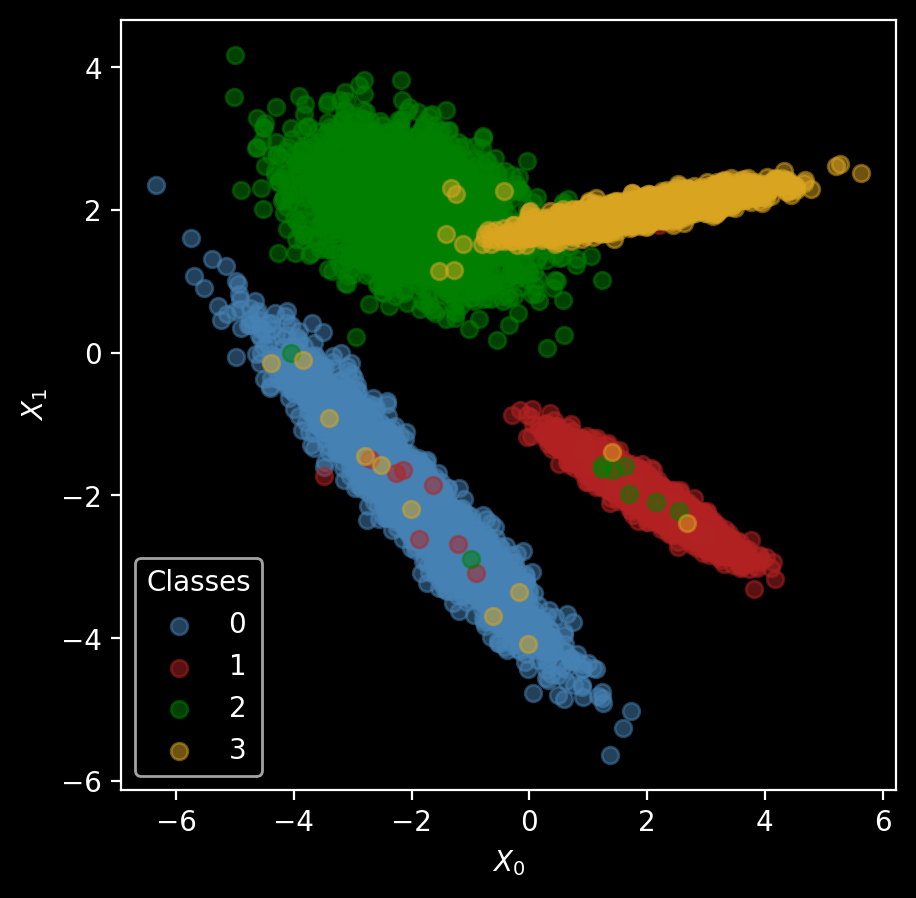

In [79]:
# Create arrays for the inputs (X) and target (y)
# Choose any of the three methods below:
# X, y = make_moons(n_samples=10_000, noise=0.2)
# X, y = make_circles(n_samples=10_000, noise=0.05)
X, y = make_classification(
    n_samples=10_000, 
    n_classes=4, 
    n_features=2,  # total number of features
    n_informative=2,
    n_redundant=0, 
    n_repeated=0, 
    n_clusters_per_class=1,
    class_sep=2.0  # larger values create clusters farther apart
)

# Cast to the same data type used for the network's parameters
X = X.astype(np.float32)
# Encode y_target to match the format for computing loss
y_target = one_hot_encode(y).astype(np.uint8)

print(f"Input shape: {X.shape}")
print(f"Target shape: {y_target.shape}")

# All at once, using default colors
# plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, s=50)
# plt.show()

colors_list = ['steelblue', 'firebrick', 'green', 'goldenrod', 'slateblue', 'dimgray', 'saddlebrown', 'tomato', 'lightgreen', 'darkorange']

fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
# Plot each class label
for n, color in zip(np.unique(y), colors_list):
    ax.scatter(X[y==n, 0], X[y==n, 1], alpha=0.5, label=n, c=color)
plt.legend(title='Classes')


plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.show()

### Initialize the model

In [114]:
model = nn(
    input_dim = X.shape[1],
    n_layers = 4,
    neurons_per_layer = [4, 10, 6, np.unique(y).size],
    bias = True,
    activation = 'relu',
    lambda_ = 0.1,
    loss_fn = 'cross_entropy',
    alpha = 0.001,
    dtype = np.float32,
    seed = None)

print("Model weights")
for n in range(model.n_layers):
    print(f"Layer {n+1} parameters: {model.params[n+1].shape}")
print(f"Total parameters: {model.n_params:,.0f}")

Model weights
Layer 1 parameters: (3, 4)
Layer 2 parameters: (5, 10)
Layer 3 parameters: (11, 6)
Layer 4 parameters: (7, 4)
Total parameters: 156


Examine how inputs flow through the network: the output from a layer (it's _activations_ or just _output_) becomes the input to the next layer, where it is multiplied with that layer's weights to produce _z_ for that layer. That _z_ is fed through an activation function, then a column of `1`s is added to it creating the _output_ to be passed to the next layer down.

In [115]:
y_hat = model.predict(X[:10])  # Run this to populate the model.outputs dictionary
# print(f"Predictions:\n{y_hat}")
# print(f"Targets:\n{y_target[:100]}")
# loss = cross_entropy_loss(y_hat, y_target[:10])
# print(f"Loss:\n{loss}")
# print('=' * 30)

for n, layer in model.outputs.items():
    if n > 0:
        # print(f"Layer {n}, input:  {model.outputs[n-1]['activation'].shape}")
        print(f"Layer {n}, params: {model.params[n].shape}")
        print(f"Layer {n}, z:      {model.outputs[n]['z'].shape}")
    print(f"Layer {n}, output: {layer['activation'].shape}")
    print('-' * 25)

Layer 0, output: (10, 3)
-------------------------
Layer 1, params: (3, 4)
Layer 1, z:      (10, 4)
Layer 1, output: (10, 5)
-------------------------
Layer 2, params: (5, 10)
Layer 2, z:      (10, 10)
Layer 2, output: (10, 11)
-------------------------
Layer 3, params: (11, 6)
Layer 3, z:      (10, 6)
Layer 3, output: (10, 7)
-------------------------
Layer 4, params: (7, 4)
Layer 4, z:      (10, 4)
Layer 4, output: (10, 4)
-------------------------


### Train the model
Since the dataset has only 10,000 points, I am training on batches of the entire dataset at once (without creating a train-test split).

In [117]:
print(f"Accuracy of the model at {model.n_steps:,.0f} steps: {model.accuracy(X, y_target):.2%}")
model.train(X, y_target, n_epochs=1_000, batch_size=X.shape[0])
print(f"Accuracy of the model at {model.n_steps:,.0f} steps: {model.accuracy(X, y_target):.2%}")

Accuracy of the model at 1,000 steps: 88.63%
Beginning training on 10,000 samples for 1,000 epochs...


  0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy of the model at 2,000 steps: 95.03%


In [118]:
y_hat = model.predict(X[:10])
print(f"Class predictions:\n{model.classify(X[:10])}")
print(f"Class targets\n{np.argmax(y_target[:10], axis=1)}")

Class predictions:
[0 1 1 0 3 1 2 0 3 0]
Class targets
[0 1 1 0 3 1 2 0 3 0]


How large are the parameter values? When using a regularization term (`model.lambda_ > 0`), the weights are reduced each iteration, bringing them closer to 0.

In [119]:
for n, layer in model.params.items():
    print(f"Layer {n}: max: {np.max(layer):,.3f}, min: {np.min(layer):,.3f}, avg: {np.mean(layer):,.3f}")

Layer 1: max: 1.485, min: -1.669, avg: -0.043
Layer 2: max: 1.723, min: -3.299, avg: -0.032
Layer 3: max: 2.113, min: -2.428, avg: 0.023
Layer 4: max: 2.875, min: -1.717, avg: 0.092


Examine the overall accuracy of the model by plotting its predictions:

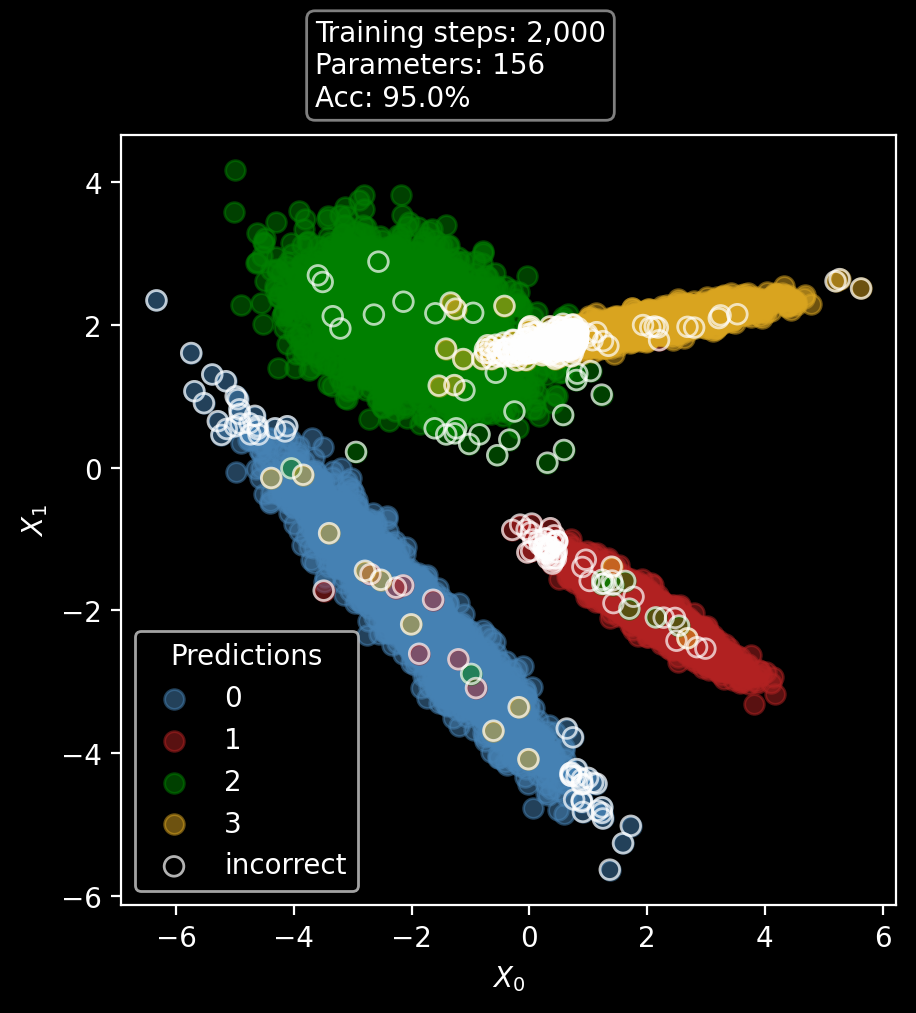

In [120]:
# Predict a class for each sample
y_hat = model.classify(X)

fig, ax = plt.subplots(figsize=(5, 5), dpi=200)

# Plot target values
for n, color in zip(np.unique(y), colors_list):
    ax.scatter(X[y==n, 0], X[y==n, 1], alpha=0.5, label=n, s=50, c=color)


# Highlight incorrect predictions
mask_incorrect = (y_hat != y)
ax.scatter(X[mask_incorrect, 0], X[mask_incorrect, 1], label='incorrect',
           edgecolor='white', s=50, facecolors='none', alpha=0.7)

# Calculate accuracy and add a textbox with metrics
# see: https://matplotlib.org/stable/gallery/text_labels_and_annotations/placing_text_boxes.html
num_correct = np.sum(y_hat == y)
acc = num_correct / y_hat.shape[0]  # the number of samples
textstr = '\n'.join((
        f"Training steps: {model.n_steps:,.0f}",
        f"Parameters: {model.n_params}",
        f"Acc: {acc:.1%}"
    ))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='black', alpha=0.5)

# place a text box in upper middle in axes coords
ax.text(0.25, 1.15, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# ax.set_title(f"Number of parameter updates: {model.n_steps}")
ax.set_xlabel('$X_0$')
ax.set_ylabel('$X_1$')
ax.legend(title='Predictions')
plt.show()

## Regression

X: (10000, 7)
y: (10000, 1)


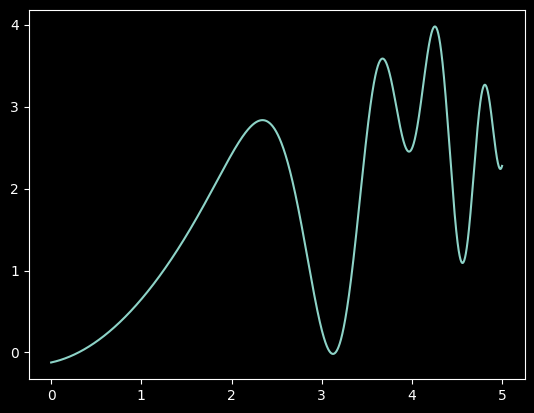

In [256]:
rng = np.random.default_rng()
X = np.linspace(0, 5, 10_000).astype(np.float32)[:, np.newaxis]
y = (np.cos(X/2 - 0.5) + 0.15*X**2 - np.cos(0.2*X**3) + np.sin(0.5*X**2)).astype(np.float32)

# Add features
X = np.concatenate((X, X**2, np.sin(X), np.cos(X), np.cos(X**2), np.sin(X**2), np.cos(X**3)), axis=1)

print(f"X: {X.shape}")
print(f"y: {y.shape}")

plt.plot(X[:, 0], y)
plt.show()

Initialize the model

In [257]:
model = nn(
    input_dim = X.shape[1],
    n_layers = 4,
    neurons_per_layer = [4, 10, 6, 1],
    bias = True,
    activation = 'relu',
    lambda_ = 0.1,
    loss_fn = 'mse',
    alpha = 0.001,
    dtype = np.float32,
    seed = None)

print("Model weights")
for n in range(model.n_layers):
    print(f"Layer {n+1} parameters: {model.params[n+1].shape}")
print(f"Total parameters: {model.n_params:,.0f}")

Model weights
Layer 1 parameters: (8, 4)
Layer 2 parameters: (5, 10)
Layer 3 parameters: (11, 6)
Layer 4 parameters: (7, 1)
Total parameters: 155


In [258]:
y_hat = model.predict(X[:10])  # Run this to populate the model.outputs dictionary

for n, layer in model.outputs.items():
    if n > 0:
        # print(f"Layer {n}, input:  {model.outputs[n-1]['activation'].shape}")
        print(f"Layer {n}, params: {model.params[n].shape}")
        print(f"Layer {n}, z:      {model.outputs[n]['z'].shape}")
    print(f"Layer {n}, output: {layer['activation'].shape}")
    print('-' * 25)

Layer 0, output: (10, 8)
-------------------------
Layer 1, params: (8, 4)
Layer 1, z:      (10, 4)
Layer 1, output: (10, 5)
-------------------------
Layer 2, params: (5, 10)
Layer 2, z:      (10, 10)
Layer 2, output: (10, 11)
-------------------------
Layer 3, params: (11, 6)
Layer 3, z:      (10, 6)
Layer 3, output: (10, 7)
-------------------------
Layer 4, params: (7, 1)
Layer 4, z:      (10, 1)
Layer 4, output: (10, 1)
-------------------------


How large are the parameter values? When using a regularization term (`model.lambda_ > 0`), the weights are reduced each iteration, bringing them closer to 0.

In [270]:
for n, layer in model.params.items():
    print(f"Layer {n}: max: {np.max(layer):,.3f}, min: {np.min(layer):,.3f}, avg: {np.mean(layer):,.3f}")

Layer 1: max: 2.375, min: -2.199, avg: -0.041
Layer 2: max: 1.831, min: -3.143, avg: -0.403
Layer 3: max: 1.994, min: -1.943, avg: 0.056
Layer 4: max: 2.200, min: -0.723, avg: 0.409


Training

In [285]:
print(f"Training steps so far: {model.n_steps:,.0f}.")
model.activation = 'relu'
model.train(X, y, n_epochs=1_000, batch_size=X.shape[0])
print(f"Training steps so far: {model.n_steps:,.0f}.")

Training steps so far: 14,000.
Beginning training on 10,000 samples for 1,000 epochs...


  0%|          | 0/1000 [00:00<?, ?it/s]

Training steps so far: 15,000.


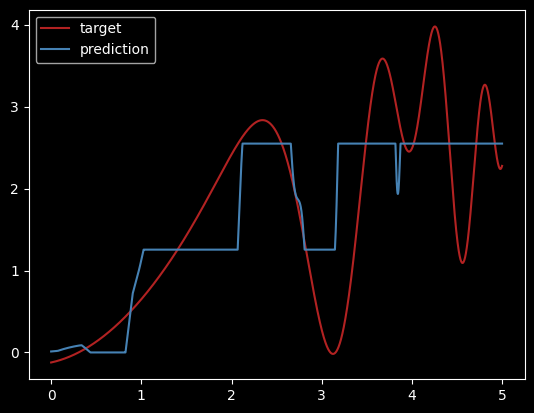

In [286]:
y_hat = model.predict(X)

plt.plot(X[:, 0], y, c='firebrick', label='target')
plt.plot(X[:, 0], y_hat, c='steelblue', label='prediction')
plt.legend()
plt.show()

## Word embeddings
In this section, I train my network to create word embeddings following the _skipgram_ method of Word2Vec.

For reference on the algorithm, [Jay Alammar's blog post on Word2Vec](https://jalammar.github.io/illustrated-word2vec/#skipgram) is helpful.

Additional packages

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

# Alternative network implementation
In this section, I create a neural network where the weight and bias parameters are stored as separate arrays.

Following the network class (`nn_bias`) is a [comparison](#version-comparison) of both versions.

Here are some key takeaways, where `nn` refers to the original network (above) with weights and biases combined into one parameter array per layer, and `nn_bias` refers to the alternative network (below) with weights and biases stored and operated on as separate arrays in each layer.

For the metrics in this table, I used the `make_circles` dataset from the three options provided in the [Version comparison](#version-comparison) section.

| Version                | `nn`             | `nn_bias`        |
|------------------------|------------------|------------------|
| Loss, 1000 epochs      | 0.621            | 0.651            |
| Accuracy               | 66.71%           | 64.58%           |
| Time per training step | 9.06 ms ± 894 µs | 11.8 ms ± 874 µs |

In [140]:
class nn_bias():
    '''Create a fully connected neural network with a configurable number of
    layers and neurons. Differs from `nn` by having a separate bias parameter
    rather than including the bias as a row in the weight matrix.'''
    def __init__(
            self,
            input_dim: int,
            n_layers: int, 
            neurons_per_layer: Union[int, list[int]], 
            bias: Union[bool, list[bool]] = True,
            activation: str='relu',
            lambda_: float = 0.0,
            loss_fn: str = 'cross_entropy',
            alpha: float = 0.001,
            dtype: np.dtype = np.float32,
            seed: Union[int, None] = None):
        '''Instantiate a neural network as a model object that performs
        computations on input data and returns the outputs
        of those computations. Parameters (weights and biases) are
        initialized to normally distributed random values with mean 0 
        and standard deviation of 1.

        Differs from `nn` by having a separate bias paramete rather than
        including the bias as a row in the weight matrix.

        Parameters
        ----------
        input_dim: int
            The dimension of the inputs to the model (i.e, the number
            of features per input sample).
        n_layers: int
            The number of layers in the network including all hidden layers
            and the output layer.
        neurons_per_layer: {int, list[int]}
            The number of neurons in each layer of the network. If an `int`,
            then all layers will have the same number of neurons. If a
            `list`, then its `len()` must equal `n_layers`, where each
            element in the list is the number of neurons in the 
            corresponding layer of the network.
        bias: {bool, list[bool]}, default = True
            Whether to include a bias term for the neurons in the network.
            If `True`, all neurons in the network will have a bias term.
            If a list of `bool` values is provided, each layer of the network
            will (or won't) have a bias term for its neurons based on the
            corresponding element in the list. If a list, the number of
            elements must equal `n_layers`.
        activation: {'relu', 'sigmoid'}, default='relu'
            The activation function to use after passing input through each
            linear layer.
        lambda_: float in the range [0.0, inf), default=0.0
            The weighting factor for the regularizing
            term in the loss calculation. If set to 0.0,
            no regularization will be used. The larger
            this value, the more weights are penalized
            and the smaller the weights will be after
            training through gradient descent.
        loss_fn: {'cross_entropy', 'ce', 'mean_squared_error', 'mse'}
            The loss function used for the network. Valid values are
            'cross_entropy' or 'mean_squared_error' or an abbreviation.
            Use 'mean_squared_error' for regression tasks and set the
            output layer to a single neuron.
            Use 'cross_entropy' for classification tasks and set
            the number of output neurons to the number of possible classes.
            Softmax is automatically applied after the output layer when
            using 'cross_entropy' loss.
        alpha: float, default=0.001
            The learning rate, which scales the step size taken during
            each pass through gradient descent. Gradients are calculated
            in the nn.backward() method and descent happens in nn.step().
        dtype: np.dtype, default=np.float32
            The data type to use for network parameters. Inputs to the network
            should also be in this same data type. NumPy's default is float64,
            but most neural networks use float32 or float16 precision to save
            memory and computation resources.
        seed: int, default=None
            For reproducibility, set a seed that will be used
            when initializing parameter values. 

        Returns
        -------
        self: an instance of `nn` with randomly initialized weights.

        Methods
        -------
        forward(input): compute a forward pass through the network,
            returning the output from the final layer.
        predict(input): alias of `forward()`
        classify(input): predict the class for each sample. For classification
            tasks only (not regression).
        backward(input, target): compute a backward pass through the network,
            storing the partial derivatives of the parameters
            with respect to the loss.
        zero_grad(): clears (zeros-out) the stored gradients.
        step(): update the parameters by taking a step (scaled by alpha)
            in the negative direction of the gradient.

        Attributes
        ----------
        params: a dict of the network's parameters by layer
        n_params: the total number of parameters in the network,
            including weights and biases.
        grad: a dict of the gradients for each of the parameters
            in the network, computed after calling backward().
        outputs: a dict of the intermediate outputs after each layer,
            including inputs to activation functions (`z`) and the activations
            after passing through activation functions.
            Used for backpropagation.
        input_dim: the size of the input that will be passed into the
            network. The network will expect all inputs to have this
            same dimension. Since each input sample is a vector, this
            is the number of features in an input row.
        n_layers: The number of layers in the network, including hidden
            layers and the output layer (excluding the input).
        neurons_per_layer: An integer or a list of integers representing
            the number of neurons in each layer.
        bias: A boolean value or a list of boolean values representing
            whether each layer has a bias term added to it.
        '''
        # Validate arguments
        if type(input_dim) != int:
            raise TypeError(f"input_dim must be an integer, but the provided value was: {type(input_dim)}")
        if type(n_layers) != int:
            raise TypeError(f"n_layers must be an integer, but the provided value was: {type(n_layers)}")
        if type(neurons_per_layer) not in (int, list):
            raise TypeError(f"neurons_per_layer must be an int or a list of int, not: {type(neurons_per_layer)}")
        elif type(neurons_per_layer) == list:
            if len(neurons_per_layer) != n_layers:
                raise ValueError(f"If neurons_per_layer is a list, it must have the same number of elements as n_layers ({n_layers}).")
            if any([type(i) != int for i in neurons_per_layer]):
                raise TypeError("neurons_per_layer must be an int or a list of int. Not all elements provided in neurons_per_layer were of the int type.")
        if type(bias) not in (bool, list):
            raise TypeError(f"bias must be a bool or a list of bool, not {type(bias)}")
        elif type(bias) == list:
            if len(bias) != n_layers:
                raise ValueError(f"If bias is a list, it must have the same number of elements as n_layers ({n_layers}).")
            if any([type(i) != bool for i in bias]):
                raise TypeError("bias must be a bool or a list of bool. Not all elements provided in bias were of the bool type.")
        if activation not in ('relu', 'sigmoid'):
            raise ValueError(f"activation must be a str, either 'relu' or 'sigmoid', not {activation}")
        if type(lambda_) != float:
            raise TypeError(f"The regularizing strength parameter, lambda_, must be of type `float`, not {type(lambda_)}")
        if type(loss_fn) != str:
            raise TypeError(f"loss_fn must be a str value, not {type(loss_fn)}")
        elif loss_fn[0] not in ['c', 'm']:
            raise ValueError(f"loss_fn must be 'cross_entropy', 'mean_squared_error', or an abbreviation, not {loss_fn}")
        if type(alpha) != float:
            raise TypeError(f"The learning rate parameter, alpha, must be of type `float`, not {type(alpha)}")

        # Update object's parameters (equivalent to self.n_layers = n_layers; self.bias = bias; ...)
        self.__dict__.update(locals())

        # Set up random number generator.
        self.rng = np.random.default_rng(self.seed)

        # If neurons_per_layer and bias are individual values, convert them 
        # to lists to use when creating layers
        if type(neurons_per_layer) == int:
            neurons_per_layer = [neurons_per_layer for _ in range(n_layers)]
        if type(bias) == bool:
            bias = [bias for _ in range(n_layers)]
    
        # Create layers (parameters)
        # If you want to calculate gradients through the inputs, start these
        # dicts at 0 (rather than 1) and update the iteration loop in the
        # backward() method to go all the way to the 0th layer (rather 
        # than layer 1).
        self.params = {}
        self.grad = {}
        input_sizes = [input_dim]
        input_sizes.extend(neurons_per_layer[:-1])
        for n in range(n_layers):
            w, b = self._linear_layer(
                input_sizes[n], neurons_per_layer[n], bias[n])
            self.params[n+1] = {'weights': w, 'bias': b}
            # Initialize gradients to 0s
            self.grad[n+1] = {'weights': np.zeros_like(w),
                              'bias': np.zeros_like(b)}
        
        # The second expression counts bias terms only for layers with a bias
        self.n_params = (np.dot(input_sizes, neurons_per_layer) 
                         + np.dot(bias, neurons_per_layer))

        # A running count of the number of parameter updates made,
        # i.e., the number of steps taken during training
        self.n_steps = 0

        # Set a default value for the network's loss, which is updated
        # any time backward() is called
        self.loss = np.nan

        # Set the sample count used for regularization. See the backwards(),
        # step(), and zero_grad() methods for more info.
        self._num_samples = 0


    def _linear_layer(self, input_size: int, n_neurons: int, bias: bool):
        '''Create a linear layer. Used when constructing the network
        at time of instantiation.
        
        The input size determines the number of weights (rows) and the
        number of neurons determines the number of columns.
        
        The bias is a 1D NumPy array with len() equal to the n_neurons.
        '''
        # Generate the weight and bias arrays
        w = self.rng.normal(size=(input_size, n_neurons))
        if bias:
            b = self.rng.normal(size=(n_neurons))
        else:
            b = np.zeros(shape=(n_neurons))
        # Convert to the specified data type. For example, float32 saves
        # memory and computation time compared to NumPy's default float64.
        # In practice, float32 and float16 are the most common data types
        # for neural network parameters.
        return w.astype(self.dtype), b.astype(self.dtype)


    def forward(self, input: np.ndarray) -> np.ndarray:
        '''Pass inputs through the network and return the outputs from
        the final network layer.
        
        Parameters
        ----------
        input: np.ndarray
            Input to the network, either a single sample or a batch of samples
            with shape (m_samples, n_features).

        Returns
        -------
        predictions: np.ndarray
            The network's predictions based on the given input. Shape is
            (m_samples,) for regression tasks, or (m_samples, n_classes) for
            classification tasks where n_classes is the number of neurons in
            the final layer.
        '''
        # Validate input
        input_size = input.shape[1] if input.ndim > 1 else input.shape[0]
        if input_size != self.input_dim:
            raise ValueError(f"Passed input of size {input_size} does not match"
                             f" expected size of input_dim: {self.input_dim}.")
        
        if input.dtype != self.dtype:
            # See https://numpy.org/doc/stable/reference/generated/numpy.result_type.html
            warnings.warn(
                message = (f"Input data type, {input.dtype}, does not match "
                f"the data type of the network's parameters, {self.dtype}, "
                f"so all parameters will be converted to "
                f"the dtype {np.promote_types(input.dtype, self.dtype)}."),
                category = RuntimeWarning)
        
        if self.activation not in ('relu', 'sigmoid'):
            warnings.warn(
                message = (f"Activation function, '{self.activation}', is not "
                    "one of the acceptable values: ('relu', 'sigmoid'), "
                    "so the default ('relu') is being used. Use "
                    "nn.activation = 'relu' or nn.activation = 'sigmoid' "
                    "to change this setting."),
                category = UserWarning)
        # Store intermediate outputs to use with backprop, starting with
        # the input layer (0). 'z' is what goes into the activation function
        # for a given layer: the layer's inputs multiplied by its weights
        outputs = {
            0: {'z': input, 'activation': input}
        }
        
        # Compute at each layer and pass to the next
        y_hat = input
        for n in range(1, self.n_layers + 1):
            y_hat = linear(x_input=y_hat,
                           weights=self.params[n]['weights'],
                           bias=self.params[n]['bias'])
            outputs[n] = {'z': y_hat}
            if self.activation == 'sigmoid':
                y_hat = sigmoid(y_hat)
            else:
                y_hat = relu(y_hat)
            outputs[n]['activation'] = y_hat
        # Finish with softmax if using cross-entropy loss.
        if self.loss_fn[0] == 'c':
            y_hat = softmax(x_input=y_hat, axis=1)
        # Store output and activation values.
        # Softmax outputs don't need to be stored because I "skip over"
        # the softmax derivative by combining it with the derivative
        # for cross-entropy loss.
        self.outputs = outputs
        # Return final predictions
        return y_hat
        
    
    # Aliases for forward()
    __call__ = forward  # Enables calling the object like a function
    predict = forward


    # Backpropagation algorithm for computing gradients
    def backward(self, x_input: np.ndarray, y_target: np.ndarray):
        '''Compute a backward pass through the network, storing the partial
        derivatives of the parameters with respect to the loss.

        Updates the nn.grad property, which holds a list of gradients by layer
        in the network.

        Parameters
        ----------
        x_input: np.ndarray
            Input to the network, either a single sample or a batch of samples
            with shape (m_samples, n_features).
        y_target: np.ndarray
            The targets to predict. If this is a regression task, the array
            will likely be of shape (m_samples,). If it is a classification
            task, the target array will be a one-hot encoded array of
            of shape (m_samples, n_classes), with a `1` in each row for the
            correct class.
        '''
        # Validate inputs
        if self.lambda_ < 0:
            raise ValueError("The regularizing term lambda_ cannot be negative. Set to a float value >= 0.0 with nn.lambda_ = val")
        
        if self.alpha < 0:
            raise ValueError("The learning rate, alpha, cannot be negative. Set to a float value >= 0.0 with nn.alpha = val")
        
        if self.loss_fn[0] == 'c' and y_target.ndim == 1:
            warnings.warn(
                message = ("The y_target array is not one-hot encoded. "
                           "It will be automatically one-hot encoded for "
                           "computing the loss. For more efficient training, "
                           "one-hot encode the entire y_target array prior "
                           "to passing it to the backwards() method."))
            y_target = one_hot_encode(y_target)

        num_samples = x_input.shape[0] if x_input.ndim > 1 else 1
        # Accumulate the number of samples used for parameter regularization;
        # that way, if parameters are not updated after each backwards pass,
        # the number of samples over which regularization is applied increases.
        # This property is zeroed out in the zero_grad() method.
        self._num_samples += num_samples
        # Set the regularization scalar. This is the derivative of L2
        # regularization when added to the loss function.
        # L2 regularization = (lambda / (2 * num_samples)) * sum(weights ** 2)
        # The derivative = (lambda / num_samples) * weights
        # The update rule for weights is:
        # weights_new = weights - alpha * (gradient + regularizing_derivative)
        # weights_new = weights - (alpha * regularizing_derivative) - (alpha * gradient)
        # Factor out "weights" from the first part:
        # weights_new = weights(1 - alpha * (lambda/num_samples))
        self.reg_scalar = 1 - (self.alpha * self.lambda_ / self._num_samples)

        # Add regularizing factor to the loss.
        # Regularizing the bias is optional; for completeness, I've chosen
        # to implement bias regularization.
        squared_weights = 0
        for n, layer in self.params.items():
            for param_type in ['weights', 'bias']:
                squared_weights += np.sum(layer[param_type] ** 2)
        loss = (self.lambda_ * squared_weights) / (2 * num_samples)

        y_hat = self.forward(x_input)
        
        # Loss function: cross_entropy or mean_squared_error
        if self.loss_fn[0] == 'c':
            loss += cross_entropy_loss(y_hat, y_target)
            # Store the derivative of the loss function
            df_loss_fn = df_cross_entropy_loss
        else:
            # mean-squared error
            loss += mse_loss(y_hat, y_target)
            df_loss_fn = df_mse_loss
        # Store the loss value; no need to average by dividing by the number of
        # samples because that averaging happens in the loss functions
        self.loss = loss
        
        if self.activation == 'sigmoid':
            df_activation_fn = df_sigmoid
        else:
            df_activation_fn = df_relu

        # [1] Derivative of loss with respect to activations.
        # ---------------------------------------------------
        # Calculate the error. For both mean-squared and cross-entropy
        # loss, this is the derivative of the loss with respect to the
        # final layer's output (after activations, before softmax).
        # equivalent to: error = (y_hat - y_target) / num_samples
        error = df_loss_fn(y_hat, y_target)

        # Store derivatives of activations
        df_outputs = {}

        layers_reverse_order = list(range(self.n_layers, 0, -1))
        for n in layers_reverse_order:
            # [2] Derivative of activations with respect to z.
            # ------------------------------------------------
            # To get the derivative of the loss with respect to z for the
            # final layer (where z is the input to the activation function),
            # multiply the error with the derivative of the activation func.
            if n == max(layers_reverse_order):
                # For the final layer, use the derivative of the loss
                # with respect to activations (which is the error from [1])
                df_outputs[n] = {'activation': (
                    error 
                    * df_activation_fn(self.outputs[n]['z']))}
                # Update the gradient for the bias, which is [1] x [2],
                # then averaged for each column (axis=0).
                # NOTE: the gradient ACCUMULATES (+=)
                self.grad[n]['bias'] += np.sum(
                    error * df_outputs[n]['activation'], axis=0) / num_samples
            else:
                # For subsequent layers, use the derivative of z
                # with respect to the prior layer activations (from [4]).
                df_outputs[n]['activation'] = (
                    df_outputs[n]['z'] 
                    * df_activation_fn(self.outputs[n]['z']))
                # Update the gradient for the bias, which is [4] x [2],
                # then averaged for each column (axis=0).
                # NOTE: the gradient ACCUMULATES (+=)
                self.grad[n]['bias'] += np.sum(
                    df_outputs[n]['z']
                    * df_outputs[n]['activation'], axis=0) / num_samples

            # [3] Derivative of z with respect to weights.
            # --------------------------------------------
            # To get the derivative of the loss with respect to the weights,
            # multiply the transposed activations from the previous layer
            # with [2].
            # NOTE: the gradient ACCUMULATES (+=).
            self.grad[n]['weights'] += (self.outputs[n-1]['activation'].T
                             @ df_outputs[n]['activation'])

            # [4] Derivative of z with respect to prior layer activations.
            # ------------------------------------------------------------
            # To get the derivative of the loss with respect to the prior
            # layer's outputs (activations), multiply [2] by the transposed
            # weights for the current layer.
            df_outputs[n-1] = {'z': (
                df_outputs[n]['activation']
                @ self.params[n]['weights'].T
            )}


    def zero_grad(self):
        '''Reset all gradients to 0.'''
        for n, layer in self.grad.items():
            layer['weights'].fill(0.0)
            layer['bias'].fill(0.0)
        # Reset the count of number of samples trained on since the last
        # gradient reset. Impacts the regularization factor in step().
        self._num_samples = 0


    def step(self):
        '''Update the weights, taking a single step in the direction of the
        negative gradient, scaled by the learning_rate.

        Note: call nn.zero_grad() to reset the gradients after taking a step,
        otherwise gradients are accumulated with each backward pass. 

        Notes
        -----
        The step uses nn.lambda_, the weighting factor for the
        regularizing term in the loss calculation. If set to 0.0, no
        regularization will be used. The larger this value, the more weights
        are penalized and the smaller the weights will be after training
        through gradient descent. The default for lambda_ is 0.0, which means
        that no regularization will be applied.

        The self.reg_scalar property is calculated during the backward pass.
        '''
        for n in range(1, self.n_layers + 1):
            for param_type in ['weights', 'bias']:
                self.params[n][param_type] = (
                    # Reduce the weights according to the regularizing setting.
                    # NOTE: Regularizing the bias is optional, but implemented
                    # here for completeness.
                    (self.params[n][param_type] * self.reg_scalar)
                    # Take a scaled step in the direction of the neg. gradient
                    - self.alpha * self.grad[n][param_type]
                )
        
        # Update the running count of parameter updates
        self.n_steps += 1


    def classify(self, x_input: np.ndarray):
        '''Predict a class based on an input.

        Applies to classification tasks only, not regression.
        
        Parameters
        ----------
        x_input: np.ndarray
            Input to the network, either a single sample or a batch of samples
            with shape (m_samples, n_features).
        
        Returns
        -------
        classifications: np.ndarray of shape (m_samples,)          
        '''
        y_hat = self.predict(x_input)
        # If the input is a single sample, add a row dimension
        # to generalize the argmax operation
        if y_hat.ndim == 1:
            y_hat = y_hat[np.newaxis, :]
        return np.argmax(y_hat, axis=1)
    

    def accuracy(self, x_input: np.ndarray, y_target: np.ndarray) -> float:
        '''Calculate the average percentage of correct predictions.
        Applies to classification tasks only, not regression.

        Parameters
        ----------
        x_input: np.ndarray
            Input to the network, either a single sample or a batch of samples
            with shape (m_samples, n_features).
        y_target: np.ndarray
            Target labels, with shape (m_samples,)
        
        Returns
        -------
        accuracy: float in the range [0.0, 1.0]
            1.0 = 100% of all samples were accurately classified.
        '''
        # If y_target is one-hot encoded, turn it into a 1D vector
        if y_target.ndim > 1:
            y_target = np.argmax(y_target, axis=1)
        n_samples = x_input.shape[0]
        labels = self.classify(x_input)
        n_correct = np.sum(labels == y_target)
        return n_correct / n_samples


    def train(
            self,
            x_train: np.ndarray,
            y_train: np.ndarray,
            x_val: Union[np.ndarray, None]=None,
            y_val: Union[np.ndarray, None]=None,
            n_epochs: int=10,
            batch_size: int=100,
            val_every_n_epochs: int=1,
            grad_accum_steps: int=1,
            shuffle: bool=True):
        '''Train the model on all `x_train` data for `n_epochs` number of loops
        through `x_train`. By default, data is shuffled each epoch.

        Parameters
        ----------
        x_train: np.ndarray of shape (m_samples, n_features)
            All the training data that will be used for one epoch.
        y_train: np.ndarray of shape (m_samples,) for regression tasks or
            (m_samples, n_classes) for classification tasks.
            The corresponding targets (labels) for the x_train data.
        x_val: np.ndarray of shape (m_samples, n_features), default=None
            If provided, this dataset will be used to score the model every
            `val_every_n_epochs` number of epochs. Results from the validation
            set will not be used to update the network's parameters. During
            model validation, the model will be scored on **all** samples in
            `x_val`, using `batch_size` for the number of samples at a time.
        y_val: np.ndarray of shape (m_samples,) for regression tasks or
            (m_samples, n_classes) for classification tasks. default=None
            The corresponding targets (labels) for the x_val data.
        n_epochs: int, default=10
            The number of loops through `x_train` that will be used to train
            the model. An epoch completes when the model has been trained on
            all samples in `x_input`, which generally takes many batches.
        batch_size: int, default=100
            The number of samples to use in each batch. Larger batch sizes
            can lead to faster training assuming the system has enough
            memory and compute resources to handle the larger batch.
        val_every_n_epochs: int, default=1
            If `x_val` is provided, this setting determines how often the model
            is scored on the validation set.
        grad_accum_steps: int, default=1
            The number of batches over which gradients should be accumulated
            prior to taking a gradient descent step. Useful when memory is
            constrained and batch size is small, since accumulating gradients
            over multiple batches has the same effect as using a larger batch
            to begin with. Larger batches are good because their gradients
            are often more reflective of the overall gradient.
        shuffle: bool, default=True
            Whether to shuffle data in `x_train` and `y_train` each epoch, and
            `x_val` and `y_val` each pass through those datasets.
        '''
        classification_task = True if self.loss_fn[0] == 'c' else False
        use_val = True if x_val != None else False

        if use_val:
            val_n_samples = x_val.shape[0]
            if val_n_samples != y_val.shape[0]:
                raise ValueError(f"x_val and y_val must have the same number of samples. (x_val: {val_n_samples:,.0f}; y_val: {y_val.shape[0]:,.0f})")
            # Set starting values for validation accuracy and loss
            val_acc = np.nan
            val_loss = np.nan
            # Load the loss function
            loss_type = cross_entropy_loss if classification_task else mse_loss
        
        n_samples = x_train.shape[0]
        if n_samples != y_train.shape[0]:
            raise ValueError(f"x_train and y_train must have the same number of samples. (x_train: {n_samples:,.0f}; y_train: {y_train.shape[0]:,.0f})")
        # If the model is used for classification and y_train or y_val are 1D
        # arrays, one-hot encode them before running them through training.
        if self.loss_fn[0] == 'c':
            if y_train.ndim == 1:
                y_train = one_hot_encode(y_train)
            if use_val and y_val.ndim == 1:
                y_val = one_hot_encode(y_val)

        print(f"Beginning training on {n_samples:,.0f} samples "
              f"for {n_epochs:,.0f} epochs...")
        
        # Set default accuracy (e.g., the network is used on a regression task)
        acc = np.nan

        # Training loop
        pbar = tqdm(range(n_epochs))
        for epoch in pbar:
            indices = np.arange(n_samples, dtype=int)
            # Avg accuracy and loss:
            # epoch_loss = 0
            # epoch_acc = 0
            # Shuffle indices in place
            if shuffle:
                self.rng.shuffle(indices)
            n_batches = np.ceil(n_samples / batch_size).astype(int)
            for batch in range(n_batches):
                start = batch * batch_size
                stop = start + batch_size if (batch + 1 != n_batches) else None
                idxs = indices[start:stop]
                self.backward(x_train[idxs], y_train[idxs])
                if batch % grad_accum_steps == 0:
                    self.step()
                    self.zero_grad()
                # epoch_loss += self.loss
                if classification_task:
                    acc = self.accuracy(x_train[idxs], y_train[idxs])
                    # epoch_acc += acc
            # Update once per epoch. To update at the batch level, uncomment
            # the batch lines and move the indentation 4 spaces to the right.
            # Use the latest accuracy and loss values (acc and self.loss) or
            # the averages across the epoch.
            # epoch_loss /= n_samples
            # epoch_acc /= n_samples
            if use_val:
                pbar.set_description(f"Epoch: {epoch+1:,.0f}/{n_epochs:,.0f}, "
                    # f"batch: {batch+1:,.0f}/{n_batches:,.0f}, "
                    f"loss: {self.loss:,.3f} (val loss: {val_loss:,.3f}), "
                    f"acc: {acc:.1%} (val acc: {val_acc:.1%})")
            else:
                pbar.set_description(f"Epoch: {epoch+1:,.0f}/{n_epochs:,.0f}, "
                    # f"batch: {batch+1:,.0f}/{n_batches:,.0f}, "
                    f"loss: {self.loss:,.3f}, accuracy: {acc:.1%}")
            # Validation loop
            if use_val and epoch % val_every_n_epochs == 0:
                val_acc = 0
                val_loss = 0
                val_indices = np.arange(val_n_samples, dtype=int)
                # Shuffle indices in place
                if shuffle:
                    self.rng.shuffle(val_indices)
                val_n_batches = np.ceil(val_n_samples / batch_size).astype(int)
                val_pbar = tqdm(range(val_n_batches))
                for val_batch in val_pbar:
                    start = batch * batch_size
                    stop = start + batch_size if (batch + 1 != n_batches) else None
                    idxs = indices[start:stop]
                    if classification_task:
                        val_acc += self.accuracy(x_val[idxs], y_val[idxs])
                    y_hat_val = self.predict(x_val[idxs], y_val[idxs])
                    val_loss += loss_type(y_hat_val, y_val[idxs])
                    val_pbar.set_description(
                        f"Validation batch: {val_batch+1:,.0f}"
                        f"/{val_n_batches:,.0f}")
                # Average the loss and accuracy values
                val_loss /= val_n_samples
                if classification_task:
                    val_acc /= val_n_samples
                else:
                    val_acc = np.nan


    # Assign "fit" as an alias for "train"
    fit = train


    def __str__(self):
        '''Return information about the object when passed to print().'''
        text = ''
        # Quick way to build the string representation, but shows more
        # information than needed (e.g., arrays for model parameters)
        # for k, v in self.__dict__.items():
        #     text += f"{k}: {v}\n"
        text += f"n_layers: {self.n_layers}"
        text += f"\ninput_dim: {self.input_dim}"
        text += "\nParams:"
        text += "\n========================="
        for n, layer in self.params.items():
            text += f"\n    {n}: weights: {layer['weights'].shape}, bias: {layer['bias'].shape}"
        text += f"\ntotal params: {self.n_params}"
        text += "\n========================="
        text += f"\nloss_fn: {self.loss_fn}"
        text += f" (for {'classification' if self.loss_fn[0] == 'c' else 'regression'} tasks)"
        text += f"\nactivation: {self.activation}"
        text += f"\nregularization strength (lambda_): {self.lambda_}"
        text += f"\nlearning rate (alpha): {self.alpha}"
        text += f"\ndata type: np.{self.dtype.__name__}"
        text += f"\ntotal training steps taken: {self.n_steps}"
        return text
    
    
    def __repr__(self):
        '''A string representation that can be used to re-create the object.
        If the model's `seed` parameter was not set at initialization,
        then eval(model.__repr__()) will **not** return the same model since
        the weights are randomly initialized.'''
        text = ('nn_bias('
            f"\n    input_dim = {self.input_dim},"
            f"\n    n_layers = {self.n_layers},"
            f"\n    neurons_per_layer = {self.neurons_per_layer},"
            f"\n    bias = {self.bias},"
            f"\n    activation = '{self.activation}',"
            f"\n    lambda_ = {self.lambda_},"
            f"\n    loss_fn = '{self.loss_fn}',"
            f"\n    alpha = {self.alpha},"
            f"\n    dtype = np.{self.dtype.__name__},"
            f"\n    seed = {self.seed}"
            '\n)'
        )
        return text



## Version comparison

Create the test dataset for comparing the networks:

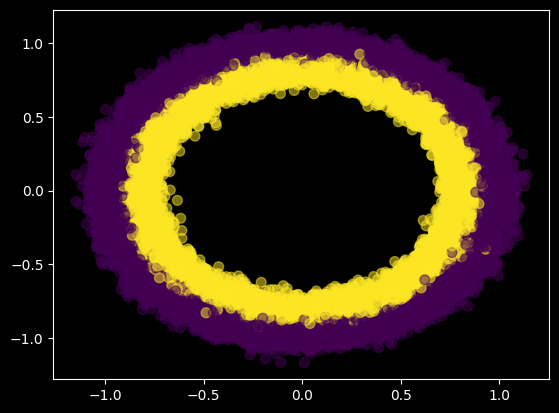

In [170]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.datasets import make_classification

# Choose any of the three methods below:
# X, y = make_moons(n_samples=10_000, noise=0.2)
X, y = make_circles(n_samples=10_000, noise=0.05)
# X, y = make_classification(
#     n_samples=10_000,
#     n_features=2,
#     n_informative=2,
#     n_redundant=0,
#     n_repeated=0,
#     n_classes=2,
#     n_clusters_per_class=1,
#     class_sep=2)


# Cast to the same data type used for the network's parameters
X = X.astype(np.float32)
# Encode y_target to match the format for computing loss
y_target = one_hot_encode(y)

plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, s=50)
plt.show()

In [194]:
# The original version, where weights and biases are combined into a single
# matrix for each layer
model = nn(
    input_dim = X.shape[1],
    n_layers = 4,
    neurons_per_layer = [4, 10, 6, np.unique(y).size],
    bias = True,
    activation = 'sigmoid',
    lambda_ = 0.1,
    loss_fn = 'cross_entropy',
    alpha = 0.001,
    dtype = np.float32,
    seed = 12)
print(f"Model 1 parameters: {model.n_params}")

# The alternate version, where weights and biases are stored separately
model2 = nn_bias(
    input_dim = X.shape[1],
    n_layers = 4,
    neurons_per_layer = [4, 10, 6, np.unique(y).size],
    bias = True,
    activation = 'sigmoid',
    lambda_ = 0.1,
    loss_fn = 'cross_entropy',
    alpha = 0.001,
    dtype = np.float32,
    seed = 12)
print(f"Model 2 parameters: {model2.n_params}")

Model 1 parameters: 142
Model 2 parameters: 142


### Loss and accuracy

In [195]:
print(f"At {model.n_steps} steps...")
print(f"Model 1 accuracy: {model.accuracy(X, y):.2%}")
print(f"Model 2 accuracy: {model2.accuracy(X, y):.2%}")
for n in range(1000):
    model.backward(X, y_target)
    model2.backward(X, y_target)
    if n == 0:
        print(f"Model 1 loss: {model.loss:,.5f}")
        print(f"Model 2 loss: {model2.loss:,.5f}")
    model.step()
    model2.step()
    model.zero_grad()
    model2.zero_grad()
print(f"\nAfter training for {model.n_steps:,.0f} epochs...")
print(f"Model 1 accuracy: {model.accuracy(X, y):.2%}")
print(f"Model 2 accuracy: {model2.accuracy(X, y):.2%}")
print(f"Model 1 loss: {model.loss:,.5f}")
print(f"Model 2 loss: {model2.loss:,.5f}")

At 0 steps...
Model 1 accuracy: 50.71%
Model 2 accuracy: 50.71%
Model 1 loss: 0.69342
Model 2 loss: 0.69342

After training for 1,000 epochs...
Model 1 accuracy: 66.710%
Model 2 accuracy: 64.580%
Model 1 loss: 0.62133
Model 2 loss: 0.65177


### Speed
After both networks have trained for many iterations, their speed is very similar, though `nn` ("Model 1") consistently runs faster than `nn_bias` ("Model 2")

Model 1 performance:

In [198]:
%%timeit
model.backward(X, y_target)
model.step()
model.zero_grad()

9.06 ms ± 894 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Model 2 performance:

In [199]:
%%timeit
model2.backward(X, y_target)
model2.step()
model2.zero_grad()

11.8 ms ± 874 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Parameter sizes
Here, I check the max and min of the parameters in each of the networks, trying to understand how the regularization term impacts the two models differently.

On average, `nn` might tend to have larger parameter weights (further from 0) than `nn_bias`, but `nn_bias` might have more extreme values than `nn`. Each time I run these cells on a new dataset, the results are slightly different, not as consistent as what is observed in speed.

`nn`, Model 1:

In [200]:
for n, layer in model.params.items():
    print(f"{n}, max: {np.max(layer):,.3f}, min: {np.min(layer):,.3f}, "
          f"avg: {np.mean(layer):,.3f}")

1, max: 4.890, min: -7.756, avg: -0.719
2, max: 3.852, min: -9.169, avg: -0.152
3, max: 5.894, min: -8.524, avg: -0.220
4, max: 9.318, min: -8.563, avg: -0.392


`nn_bias`, Model 2:

In [201]:
for n, layer in model2.params.items():
    print(f"{n}, W: max: {np.max(layer['weights']):,.3f}, min: {np.min(layer['weights']):,.3f}, avg: {np.mean(layer['weights']):,.3f}")
    print(f"{n}, B: max: {np.max(layer['bias']):,.3f}, min: {np.min(layer['bias']):,.3f}, avg: {np.mean(layer['bias']):,.3f}")
    print()

1, W: max: 1.842, min: -2.830, avg: -0.330
1, B: max: 0.533, min: -0.480, avg: -0.006

2, W: max: 11.740, min: -7.006, avg: 0.045
2, B: max: 2.254, min: -0.546, avg: 0.873

3, W: max: 8.457, min: -8.109, avg: -0.124
3, B: max: 2.612, min: -1.489, avg: -0.028

4, W: max: 9.164, min: -6.517, avg: -0.174
4, B: max: 0.290, min: 0.248, avg: 0.269



Compare bias terms:
For the `nn` (Model 1), this is simply the last row of each layer.

In [202]:
for n in range(model.n_layers):
    print(f"Layer {n}, model 1 bias: {np.round(model.params[n+1][-1, :], 3)}")
    print(f"Layer {n}, model 2 bias: {np.round(model2.params[n+1]['bias'], 3)}")
    print()

Layer 0, model 1 bias: [-4.161  3.738 -6.786  4.079]
Layer 0, model 2 bias: [-0.48   0.533 -0.219  0.142]

Layer 1, model 1 bias: [ 0.66  -1.329  1.257  3.473  0.366  1.585  0.204  1.248 -0.019  0.618]
Layer 1, model 2 bias: [ 0.911 -0.546  1.231  1.523  1.054  1.086  1.034  2.254  0.181  0.   ]

Layer 2, model 1 bias: [-1.784 -1.505 -0.227 -0.304  2.335 -0.343]
Layer 2, model 2 bias: [-0.868 -1.489  0.405 -0.18   2.612 -0.647]

Layer 3, model 1 bias: [ 1.182 -0.807]
Layer 3, model 2 bias: [0.248 0.29 ]



### Model representation comparison

In [ ]:
# You can create a new model with the same parameters like this:
# new_model = eval(model.__repr__())

In [182]:
model  # same as model.__repr__()

nn(
    input_dim = 2,
    n_layers = 4,
    neurons_per_layer = [4, 10, 6, 2],
    bias = True,
    activation = 'sigmoid',
    lambda_ = 0.1,
    loss_fn = 'cross_entropy',
    alpha = 0.001,
    dtype = np.float32,
    seed = 12
)

In [183]:
print(model)

n_layers: 4
input_dim: 2
Params:
    1: (3, 4)
    2: (5, 10)
    3: (11, 6)
    4: (7, 2)
total params: 142
loss_fn: cross_entropy (for classification tasks)
activation: sigmoid
regularization strength (lambda_): 0.1
learning rate (alpha): 0.001
data type: np.float32
total training steps taken: 1811


In [184]:
print(model2)

n_layers: 4
input_dim: 2
Params:
    1: weights: (2, 4), bias: (4,)
    2: weights: (4, 10), bias: (10,)
    3: weights: (10, 6), bias: (6,)
    4: weights: (6, 2), bias: (2,)
total params: 142
loss_fn: cross_entropy (for classification tasks)
activation: sigmoid
regularization strength (lambda_): 0.1
learning rate (alpha): 0.001
data type: np.float32
total training steps taken: 1811


# Ideas for next steps
- Perform an embedding of products for market basket analysis. For example, see this [Kaggle dataset](https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset?select=Groceries_dataset.csv)
- Use the `jax.numpy` library to add a line in the [Required packages](#required-packages) section that places all the neural network calculations on the GPU (if available), leading to significant speed-ups in training time.